Inspect integrator output values, grouping by different equivalence classings on the dataset.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [8]:
from pathlib import Path

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

from src.datasets.speech_equivalence import SpeechEquivalenceDataset, SpeechHiddenStateDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, iter_dataset

In [4]:
model_dir = "outputs/models/timit/w2v2_6/rnn_8/phoneme"
output_dir = "outputs/notebooks/timit/w2v2_6/rnn_8/phoneme/plot"
dataset_path = "outputs/preprocessed_data/timit"
equivalence_path = "outputs/equivalence_datasets/timit/w2v2_6/phoneme/equivalence.pkl"
hidden_states_path = "outputs/hidden_states/timit/w2v2_6/hidden_states.pkl"
state_space_specs_path = "outputs/state_space_specs/timit/w2v2_6/state_space_specs.pkl"
embeddings_path = "outputs/model_embeddings/timit/w2v2_6/rnn_8/phoneme/embeddings.npy"

metric = "cosine"

In [5]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

/home/jgauthier/u/transformers/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [6]:
with open(equivalence_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = torch.load(f)
with open(hidden_states_path, "rb") as f:
    hidden_state_dataset: SpeechHiddenStateDataset = torch.load(f)

In [15]:
ds = datasets.Dataset.from_generator(
    iter_dataset, gen_kwargs=dict(equiv_dataset=equiv_dataset,
                                    hidden_state_dataset=hidden_state_dataset,
                                    max_length=model.config.max_length,
                                    num_examples=min(10000, equiv_dataset.num_instances),
                                    infinite=False)) \
    .with_format("torch")

<Axes: >

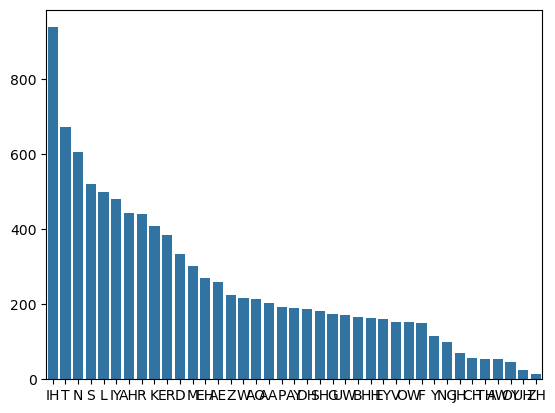

In [16]:
class_counts = torch.bincount(ds["example_class"], minlength=len(equiv_dataset.class_labels)).numpy()
sns.barplot(pd.Series(class_counts, index=equiv_dataset.class_labels).sort_values(ascending=False))

In [17]:
losses, idxs = [], []

def compute_loss_batch(batch, batch_idxs):
    with torch.no_grad():
        model_output = model(batch["example"], batch["example_length"],
                             batch["pos"], batch["pos_length"],
                             batch["neg"], batch["neg_length"],
                             in_batch_soft_negatives=False,
                             loss_reduction=None)
    losses.append(model_output.loss.numpy())
    idxs.append(batch["example_idx"].numpy())
ds.map(compute_loss_batch, batched=True, with_indices=True, batch_size=32)

losses = np.concatenate(losses)
idxs = np.concatenate(idxs)

loss_df = pd.DataFrame({"loss": losses, "idx": idxs, "class": equiv_dataset.Q[idxs]})
loss_df["class_label"] = loss_df["class"].map(dict(enumerate(equiv_dataset.class_labels)))

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [25]:
loss_df

,loss,idx,class,class_label
0,-0.030241,541084,20,AE
1,-0.138083,296986,14,W
2,-3.702910,376987,1,IH
3,-19.725323,68967,6,AH
4,-0.009975,614304,32,NG
...,...,...,...,...
9995,-19.307858,185546,7,K
9996,0.385330,482788,13,R
9997,-4.547998,97379,11,N
9998,0.070209,383279,10,T


<Axes: xlabel='loss'>

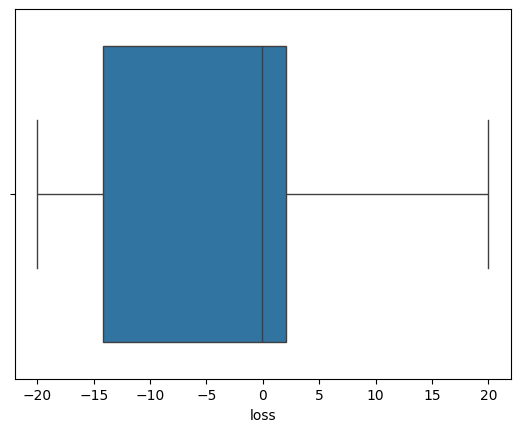

In [28]:
sns.boxplot(data=loss_df, x="loss")

In [27]:
loss_df.to_csv(Path(output_dir) / "loss.csv", index=False)

<Axes: xlabel='class_label', ylabel='loss'>

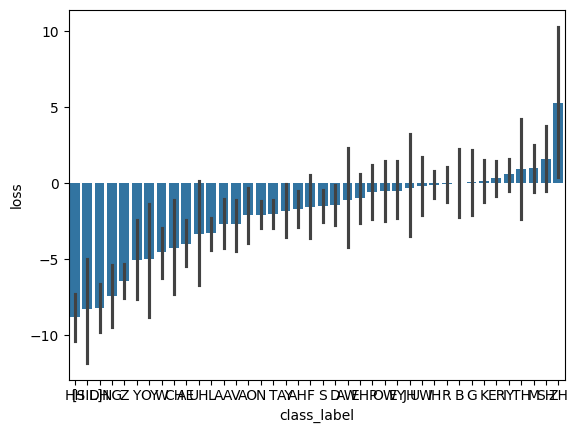

In [26]:
sns.barplot(data=loss_df, x="class_label", y="loss",
            order=loss_df.groupby("class_label")["loss"].mean().sort_values().index)